# IF240 - Machine Learning and Deep Learning

## TP 2 - Naive Bayes and Evaluation Metrics

By Michaël Clément and Aurélie Bugeau

Credits:  Vincent Lepetit, Varun Kumar, Mohit Deshpande

### Objectives 
The objective of the practice is to classifiy emails from a dataset as spam or non-spam.

You will implement the Naive Bayes classifier, and test the model with several validation metrics.

### Libraries

The code needs to import the following libraries:

In [ ]:
import pandas as pd
import numpy as np
import math
import re
import string
import matplotlib.pyplot as plt

## 1. Dataset

#### Presentation and Loading
The dataset used here contained 747 spam and 4825 non-spam (i.e. ham) mails. 
Emails in the corpus have been already pre-processed in the following ways:

- Removal of stop words (and, the, of, etc)
- Lemmatization (inludes, included, include are now all considered as include)

In [ ]:
# Open the dataset and count the number of spam/ham mails
mails = pd.read_csv("../assets/spamham.csv")
count = mails['Category'].value_counts()
print(count)
print(mails.head())


ham     4825
spam     747
Name: Category, dtype: int64
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


#### Training and evaluation sets
Split the dataset into training and evaluation sets.

In [ ]:
# Split data as train and evaluation sets
msk = np.random.rand(len(mails)) < 0.8
training_set = mails[msk]
testing_set = mails[~msk]

## 2. Naive Bayes Classification
The classifier must be able to predict the label based on the text by implementing the following pseudo code:

`if (P('ham' | message ) > P( 'spam' | message )) return ‘ham’
else return ‘spam’`

where
$$ P(ham | message)~=~ {\rm Probability ~that~ email~ is ~ham~ given~ that~ it~ has~ certain~ features~} $$
$$ P(spam | message)~=~ {\rm Probability ~that~ email~ is ~spam~ given~ that~ it~ has~ certain~ features~} $$

The features will be based on the number of occurence of each word in the message.

(See the bag-of-words model: https://en.wikipedia.org/wiki/Bag-of-words_model)

### Question 1 

Apply the Naive Bayes formula in the following code to implement a classifier. You will consider that:
$$P(message | spam) = P(word1 | spam) * P(word2 | spam) *...$$

 
_Note:_ if a word in the testing dataset is not present in the training dataset, you may encounter problems as $P(new | ham)$ or $P(new | spam)$ will be 0 making all product equal to 0.
To solve this problem, we should take log on both sides. New pseudo code will be

`if (log(P('ham' | message )) > log(P('spam' | message))) return ‘ham’
else return ‘spam’`

Then 
$$ log(P(message| spam)) =  log(P(word1 | spam)) + log(P(word2 | spam)) …$$

But the problem is still not solved. If the classifier encounters a new word that is not present in our training data sets then P(new-word | category) will be 0 and log(0) is undefined. To solve this problem, you must use Laplace smoothing:

$$P(word1 | spam) = \frac{{\rm number~ of ~}word1 {\rm~belonging~ to ~category~ spam + 1}}{{\rm  number ~ of ~words~ belonging~ to ~spam ~}+{ \rm ~number ~of~ distinct ~words~ in ~training ~datasets~}}$$


In [ ]:
# Tokenize a string into words    
def tokenize(text):
    return re.split("\W+", text)

# Class for detecting spam using Naive Bayes
class SpamDetectorNB(object):
    
    def __init__(self):
        self.numberOfmessages = {} 
        self.log_class_priors = {}
        self.word_counts = {}
        self.word_index = {}
        self.vocab = set()
    

    # Compute log class priors log(𝑃(ℎ𝑎𝑚)) and log(𝑃(sp𝑎𝑚))  
    # by counting up how many spam/ham messages are in our dataset and dividing by the total number
    def log_priors(self, training_set):
        p = mails['Category'].value_counts()[0] / len(mails)
        self.log_class_priors['spam'] = np.log(p)
        self.log_class_priors['ham'] = np.log(1 - p)
        
     
    # Count how many times each word appears in a text. 
    # Returns a dictionary that contain for each word indicates the number of times it appears in text. 
    def get_word_counts(self, text):
        word_counts = {}
        list_of_words = tokenize(text)
        for word in list_of_words:
            if word.lower() not in word_counts:
                word_counts[word.lower()] = 1
            else:
                word_counts[word.lower()] += 1
        # You can use the Python dictionary method get()
        return word_counts
    
    # Create a dictionary (a vocabulary of words)
    # and count words frequency for spam and ham separately
    def get_word_frequency(self, training_set):
        self.word_counts['spam'] = {}
        self.word_counts['ham'] = {}
        for _, mail in training_set.iterrows():
            label = mail['Category']
            text = mail['Message']
            # Tokenize each message into words
            counts = self.get_word_counts(text)
            for word, count in counts.items():
                if word not in self.vocab:
                    self.word_index[word] = len(self.vocab)
                    self.vocab.add(word)
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0.0
                self.word_counts[label][word] += count
                
                
    # Compute all necessary features
    def train(self, training_set):
        self.log_priors(training_set)
        self.get_word_frequency(training_set)
        
        
    def predict(self, testing_set):
        result = []
        for _, mail in testing_set.iterrows():
            label = mail['Category']
            text = mail['Message']
            
            # Tokenize each message into words.
            counts = self.get_word_counts(text)
            
            # Initialize 𝑙𝑜𝑔(𝑃(spam|message)) and 𝑙𝑜𝑔(𝑃(ham|message)) according to log priors
            pham = self.log_class_priors['ham']
            pspam = self.log_class_priors['spam']
            # COMPLETE
            spam_count = len(self.word_counts['spam'])
            ham_count = len(self.word_counts['ham'])
            # For each message, compute 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) 
            for word, _ in counts.items():
                if word not in self.vocab: continue         
                # For each word compute log(P(w/spam)) and log(P(w/ham)) 
                pwham = np.log(self.word_counts['ham'].get(word, 1) / ham_count)
                pwspam = np.log(self.word_counts['spam'].get(word, 1)/ spam_count)
                # Update 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) 
                pham += pwham
                pspam += pwspam
            # Decide spam or ham
            if pham > pspam:
                result.append('ham')
            else:
                result.append('spam')

        return result


In [ ]:
# Apply the classifier to the spam dataset
sd = SpamDetectorNB()
sd.train(training_set)
result = sd.predict(testing_set)

### Question 2 - Accuracy and confusion matrix
Compute the precision, recall, accuracy and confusion matrix

Precision: 0.8811
recall: 1.0000
Accuracy : 0.8838
Classification error : 0.1162
Confusion matrix using SpamDetectorNB: 
 [[978 132]
 [  0  26]]


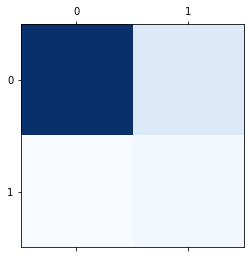

In [ ]:
# we assume that ham is positive and spam is negative
result_true = testing_set['Category'].values
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(result)):
    if result[i] == 'ham' and result_true[i] == 'ham':
        TP += 1
    elif result[i] == 'spam' and result_true[i] == 'ham':
        FP += 1
    elif result[i] == 'spam' and result_true[i] == 'spam':
        TN += 1
    elif result[i] == 'ham' and result_true[i] == 'spam':
        TP += 1

precision = (TP / (TP + FP))
recall = (TP / (TP + FN))
accuracy = ((TP + TN) / (TP + TN + FP + FN))
print("Precision: {0:.4f}".format(precision))
print("recall: {0:.4f}".format(recall))
print("Accuracy : {0:.4f}".format(accuracy))
print("Classification error : {0:.4f}".format(1 - accuracy))
M = np.array([[TP, FP], [FN, TN]])
plt.matshow(M, cmap=plt.cm.Blues)
print("Confusion matrix using SpamDetectorNB: \n", M)


### Question 3 - Naive Bayes with Scikit-learn library
The `scikit-learn` library proposes many functions for machine learning.  Study the documentation of the  `MultinomialNB` class and apply it for spam detection.

You will need to convert the dataset into arrays.

In [177]:
from sklearn.naive_bayes import MultinomialNB





### Question 4 - Evaluation with Scikit-learn library

The `scikit-learn` library also proposes  functions to evaluate machine learning methods.

Apply them to the spam detection problem.

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

# COMPLETE

# For visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmMNb.T, square=True, annot=True, fmt='d', cbar=False) # xticklabels=,yticklabels=